In [30]:
from __future__ import print_function, division
from builtins import range, input

In [31]:
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.backend as backend

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [33]:
def vgg16_avg_pool(shape):
    vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top = False)
    new_model = Sequential()
    for layer in vgg.layers:
        if (layer.__class__ == MaxPooling2D):
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [34]:
def unpreprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 126.68
    img = img[:, :, ::-1]
    return img

In [56]:
def scale_image(x):
    return (x - x.min()) / (x.max())

In [35]:
def gram_matrix(img):
    x = backend.batch_flatten(backend.permute_dimensions(img, (2, 0, 1)))
    gram = backend.dot(x, backend.transpose(x)) / img.get_shape().num_elements()
    return gram

In [36]:
def style_loss(y, t):
    return backend.mean(backend.square(gram_matrix(y) - gram_matrix(t)))

In [37]:
def minimize(fn, epochs, batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(func = fn, x0 = x, maxfun = 20)
        x = np.clip(x, -127, 127)
        print('iter: ', i, 'loss: ', l)
        losses.append(l)
    print('duration: ', datetime.now() - t0)
    plt.plot(losses)
    plt.show()
    new_img = x.reshape(*batch_shape)
    final_img = unpreprocess(new_img)
    return final_img[0]

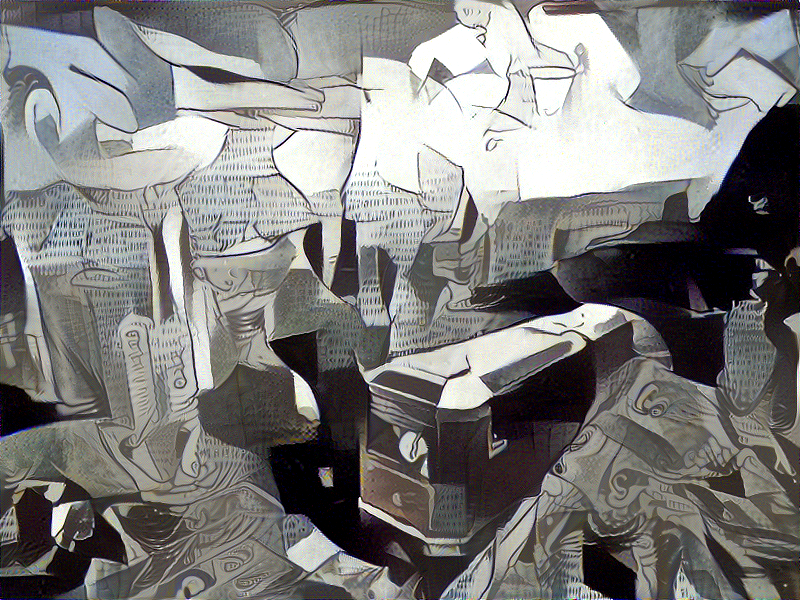

In [38]:
path = 'C:\\Users\\AAKASH\\Desktop\\Temporary\\CN ML attachments\\stonishArt.jpg'
img = image.load_img(path)
img

In [39]:
x.shape

(1, 613, 980, 3)

In [40]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [41]:
batch_shape = x.shape
shape = x.shape[1:]

In [42]:
vgg = vgg16_avg_pool(shape)

In [43]:
symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]

In [44]:
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(?, 600, 800, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_3/Relu:0' shape=(?, 300, 400, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_3/Relu:0' shape=(?, 150, 200, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_3/Relu:0' shape=(?, 75, 100, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_3/Relu:0' shape=(?, 37, 50, 512) dtype=float32>]

In [45]:
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

In [46]:
style_layer_outputs = [backend.variable(y) for y in multi_output_model.predict(x)]

In [47]:
style_layer_outputs

[<tf.Variable 'Variable_5:0' shape=(1, 600, 800, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(1, 300, 400, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(1, 150, 200, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(1, 75, 100, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(1, 37, 50, 512) dtype=float32_ref>]

In [48]:
x.shape

(1, 600, 800, 3)

In [49]:
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layer_outputs):
    print(symbolic)
    print(symbolic[0])
    print(actual[0])
    loss += style_loss(symbolic[0], actual[0])

Tensor("block1_conv1_3/Relu:0", shape=(?, 600, 800, 64), dtype=float32)
Tensor("strided_slice:0", shape=(600, 800, 64), dtype=float32)
Tensor("strided_slice_1:0", shape=(600, 800, 64), dtype=float32)
Tensor("block2_conv1_3/Relu:0", shape=(?, 300, 400, 128), dtype=float32)
Tensor("strided_slice_6:0", shape=(300, 400, 128), dtype=float32)
Tensor("strided_slice_7:0", shape=(300, 400, 128), dtype=float32)
Tensor("block3_conv1_3/Relu:0", shape=(?, 150, 200, 256), dtype=float32)
Tensor("strided_slice_12:0", shape=(150, 200, 256), dtype=float32)
Tensor("strided_slice_13:0", shape=(150, 200, 256), dtype=float32)
Tensor("block4_conv1_3/Relu:0", shape=(?, 75, 100, 512), dtype=float32)
Tensor("strided_slice_18:0", shape=(75, 100, 512), dtype=float32)
Tensor("strided_slice_19:0", shape=(75, 100, 512), dtype=float32)
Tensor("block5_conv1_3/Relu:0", shape=(?, 37, 50, 512), dtype=float32)
Tensor("strided_slice_24:0", shape=(37, 50, 512), dtype=float32)
Tensor("strided_slice_25:0", shape=(37, 50, 512)

In [50]:
grads = backend.gradients(loss, multi_output_model.input)

In [51]:
get_loss_and_grads = backend.function(inputs = [multi_output_model.input], outputs = [loss] + grads)

In [52]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [ ]:
final_img = minimize(get_loss_and_grads_wrapper, 7, batch_shape)

iter:  0 loss:  8205.7890625
iter:  1 loss:  2741.995849609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


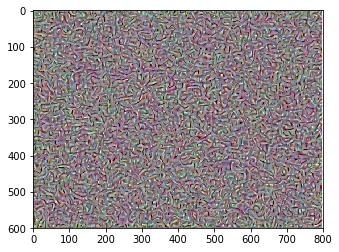

In [57]:
plt.imshow(scale_image(final_img))
plt.show()